<a/ id='top'></a>

# CSCI4022 Homework 3; K-Means

## Due Friday, February 11 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.
- There are two ways to quickly make a .pdf out of this notebook for Gradescope submission.  Either:
 - Use File -> Download as PDF via LaTeX.  This will require your system path find a working install of a TeX compiler
 - Easier: Use File ->  Print Preview, and then Right-Click -> Print using your default browser and "Print to PDF"



---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |
---


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Theory: Distance Setup; 5 pts)

In the later portion we're going to combine two distance measures by creating an average of them.  Is this valid?

Prove the following:

If $f(x,y)$ and $g(x,y)$ are both valid distance measures mapping objects $x,y$ from *some* space to $\mathbb{R}^+$, prove that $h(x,y)=a\cdot f(x,y) + b g(x,y)$ is also a valid distance measure for positive integers $a$ and $b$.


***
<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (K-Means and Initialization; 22 pts)

In the next two problems we cluster the Pokémon dataset loaded below:

In [533]:
df=pd.read_csv("../data/pokedexg13.csv")
print(df.shape)
df.head(100)

(432, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,88,Grimer,Poison,NaN,325,80,80,50,40,50,25,1,False
96,89,Muk,Poison,NaN,500,105,105,75,65,100,50,1,False
97,90,Shellder,Water,NaN,305,30,65,100,45,25,40,1,False
98,91,Cloyster,Water,Ice,525,50,95,180,85,45,70,1,False


### A)
Write a function `kmeans` that takes in a data frame, and uses a predefined distance to run k-means until convergence.  

- Check for convergence by calculating the reconstruction error after each step, and stop when the reconstruction error has changed by no more than `tol` from the previous step.
- Choose $k$ rows form the data frame at random to be the initial centroids of the clusters

Use the in-class notebook code slide, and/or textbook to guide you.

In [540]:
euclidean_distance = lambda v1, v2: math.pow((math.pow((v2[0]-v1[0]), 2) + math.pow((v2[1]-v1[1]), 2) + math.pow((v2[2]-v1[2]), 2)), 0.5)
euclidean_distance([4,2,1], [1,2,4])

4.242640687119285

In [549]:
#parameterized distance function as we will be using a different variant in pt3.
def kmeans(df, distance, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    recon_change = float("inf")
    meanerror = 0
    att = df.to_numpy()
    #gen init centroids
    cent = np.random.choice(len(att), k)
    #gets row, hp,att,def per chosen centroid
    centroids = [att[x] for x in cent]
        
    while recon_change > tol:
        #distance from centroid
        #picking centroids randomly.
        #means we run more iterations within loop 2
        err = 0
        clusters = [[] for x in range(0,k)] #store point per centroid L of L
        
        prev_error = meanerror
        prev_centroids, prev_clusters = centroids, clusters
       
        for x in range(0, len(att)): #per point - we run O(n*m) iteration
            # n = points, m = centroids.
            cent, min_distance = None, float("inf")
            for y in range(0, len(centroids)): #per centroid -> we calc distance, therefore we
                dist = distance(att[x], centroids[y]) #euclidean distance of (xyz)_1, (xyz)_2
                if dist < min_distance:
                    min_distance = dist
                    cent = y 
            clusters[cent].append(x) 
        
        for x in range(0, len(centroids)): #per centroid
            agg_val = np.zeros(3) #use this to aggregate our distance
            m = len(clusters[x]) #this is our 'n' -> number of points.
            for y in clusters[x]: #y corresponds to one point in centroid[x]
                agg_val += att[y]
            if m != 0:
                centroids[x] = agg_val/m
#             else:
#                 print(centroids[x]) #we have to get an outlier as our centroid for m == 0
            #print(agg_val/m)
        #reconstruction error
        for x in range(0, len(centroids)): #per centroid
            for y in clusters[x]:
                new_dist = np.sum(distance(att[y], centroids[x])) #we want to collapse our output 1x3 matrix into 1x1
                err += new_dist
        n = len(att)
        meanerror = err/n
        if prev_error != 0:
            recon_change = prev_error-meanerror 
        else:
            recon_change = meanerror
        #we expect our new error to be less 
        #so we take previous_error - meanerror(curr mean of error)
        #this gives us the change in error per iteration.
        #print(f"recon_change: {recon_change}")
            #we take the difference between the error of the previous and the current.
            #we want to stop if our change in mean error is less than the tolerance, as that means
            #that we are not generating better clusters.  
        if recon_change < 0:
            #we need to do 2 things here. Firstly, map indexes of points per cluster to points
            #second we want to skip a bad change -> if we have negative tolerance(more likely than < 0.05)
            clusters, centroids = prev_clusters, prev_centroids
            for x in range(len(clusters)):
                for y in range(len(clusters[x])):
                    clusters[x][y] = att[clusters[x][y]]
        elif recon_change < 0.05:
            for x in range(len(clusters)):
                for y in range(len(clusters[x])):
                    clusters[x][y] = att[clusters[x][y]]
                
    return centroids, clusters, meanerror

In [542]:
ce, cl, me = kmeans(df.iloc[:,5:8], euclidean_distance)

### B) 

Use your function to cluster the generation 1-3 Pokémon into 4 groups based on their (HP, Attack, Defense) tuples.  Make a scatter plot of the resulting assignments on an (Attack, Defense) axis.

Run the function a few times: do you get the exact same clusters every time?

In [543]:
#def plot_kmeans(cl, ce, me):
#clean up lists a bit -> we need np arrays here to do easier
def clean_inp(ce, cl):
    for x in range(0, len(cl)):
        cl[x] = np.array(cl[x])

    ce = np.array(ce)
    return ce, cl

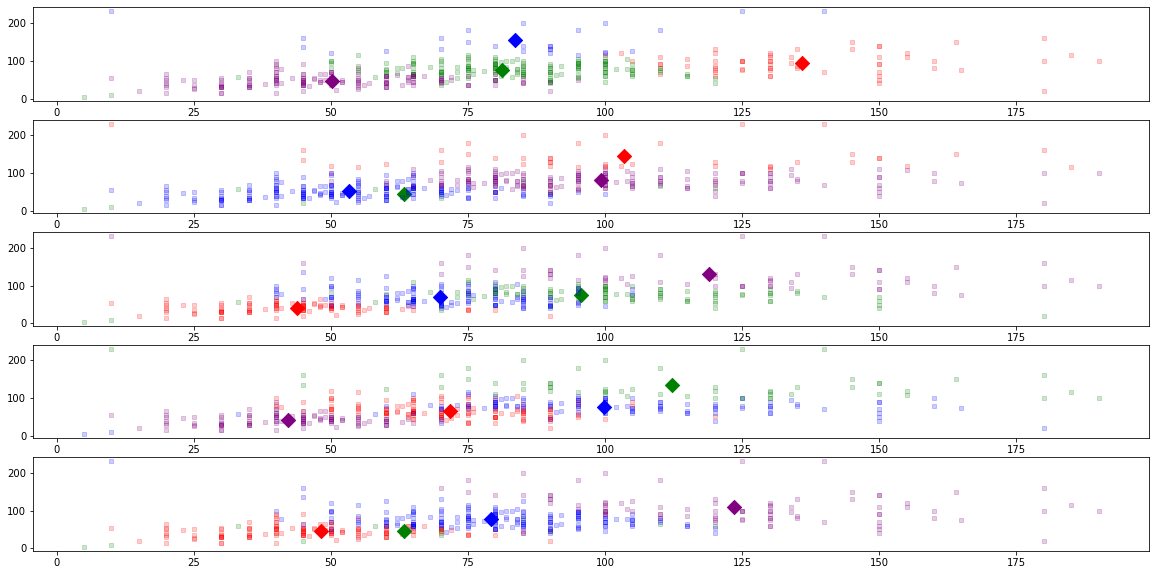

In [544]:
vals = df.iloc[:, 5:8] #get hp/att/def
iterations = 5
colors = ['red', 'green', 'blue', 'purple']
fig, ax = plt.subplots(5,1)
plt.rcParams["figure.figsize"] = (20,10)

for k in range(0,5):
    ce, cl, me = kmeans(vals, euclidean_distance)
    ce, cl = clean_inp(ce, cl)
    
    
    for x in range(0, len(cl)):
        ax[k].scatter(ce[x][1], ce[x][2], color = colors[x], marker="D", s=100)
        ax[k].scatter(cl[x][:,1], cl[x][:,2], color = colors[x], marker=",", alpha=0.2, s=15)

We definitely do not get the same clusters per run. This is due to randomness(with selection of the initial centroids) causing a different level of precision to be reached each iteration. This can be verified by viewing the mean error per kmeans run, we can see different values associated with each iteration, however they are close.

### C)

We need a way to make sure we got the *best* result for  a given value of $k$, and not a particularly unlucky one.  So in practice we usually run kmeans multiple times, and report only the best one.  So re-run your code from part **B** 20 times, and save the assignments/clusters that correspond to the lowest reconstruction error.  Make a scatter plot of the resulting assignments on an (Attack, Defense) axis.

*Implementation Idea*: Create a data frame that is 432 rows and 20 columns, fill each column with the results from a "run".  Also create a length 20 vectors for the mean reconstruction error of each run.

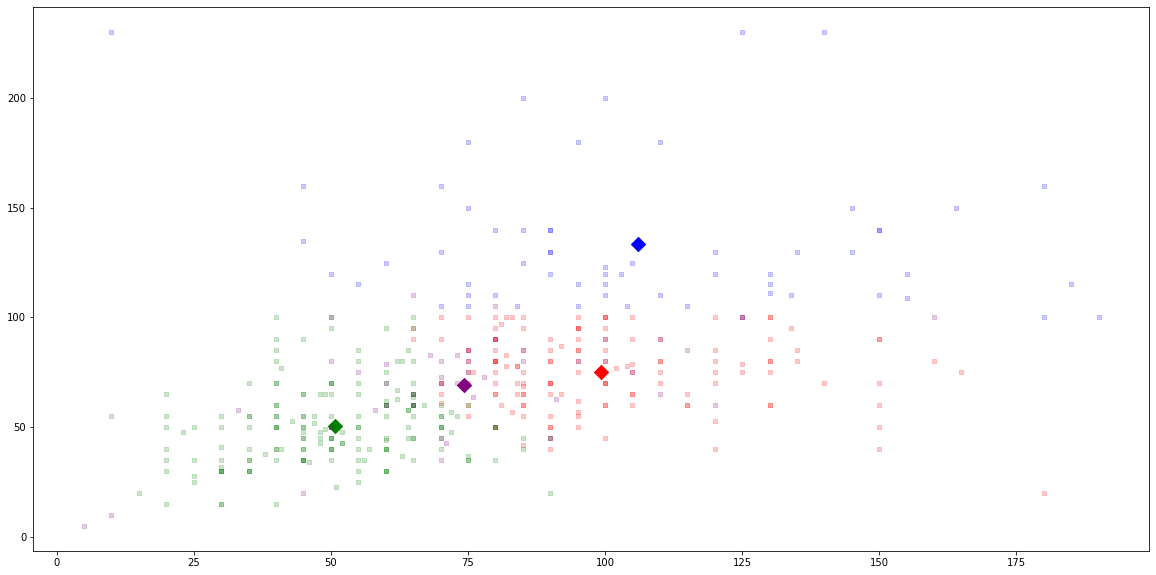

In [545]:
best_ce, best_cl, lowest_me = [], [], float("inf")
meanerrors = []
for k in range(0,20):
    ce, cl, me = kmeans(vals, euclidean_distance)
    meanerrors.append(me)
    if me < lowest_me: #we just save the clusters/centroids of the smallest meanerror
        lowest_me = me
        best_ce, best_cl = ce, cl
    
best_ce, best_cl = clean_inp(ce, cl)

for x in range(0, len(cl)):
    plt.scatter(best_ce[x][1], best_ce[x][2], color = colors[x], marker="D", s=100)
    plt.scatter(best_cl[x][:,1], best_cl[x][:,2], color = colors[x], marker=",", alpha=0.2, s=15)

In [546]:
print(f"We have a range of: {max(meanerrors)-lowest_me}")

We have a range of: 2.4476763573549043


### D)

In parts **A-C** we left $k=4$ as the number of groups.  But we also need to pick the best value of $k$!  Run K-means for $k=1,2,3,\dots ,10$.
- For each value of $k$, run the algorithm at least 10 times with random initialization
- For each $k$, select among those runs the one with the *minimum* reconstruction error
- Make a plot where $k$ is the $x$-axis and "best observed reconstruction error" is the y-axis.

Is there a visible "elbow" in the plot?  What feels like an appropriate value of $k$, here?


In [547]:
k_vals = [i for i in range(1,11)] #anyways need for x-vals of plot.
lowest_me_per_k = np.zeros(10) #index maps to lowest me per k
for k in range(1,11):
    lowest_me = float("inf")
    for x in range(10):
        _, _, me = kmeans(vals, euclidean_distance, k=k)
        lowest_me = min(lowest_me, me)
    lowest_me_per_k[k-1] = lowest_me

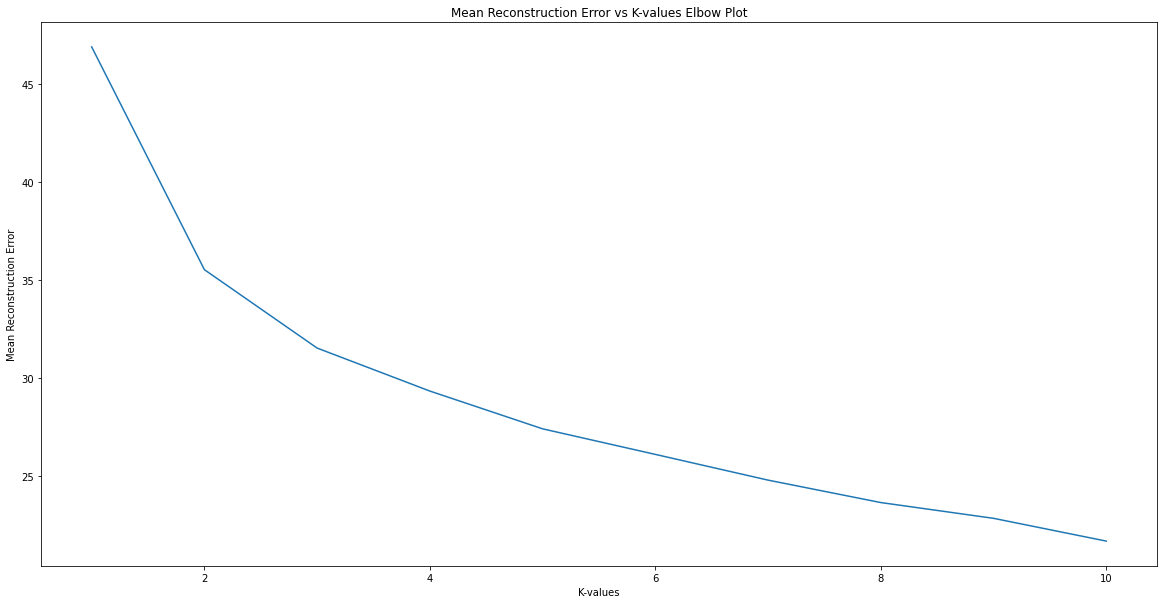

In [548]:
plt.xlabel("K-values")
plt.ylabel("Mean Reconstruction Error")
plt.title("Mean Reconstruction Error vs K-values Elbow Plot")
plt.plot(k_vals, lowest_me_per_k)

Is there a visible "elbow" in the plot? What feels like an appropriate value of  𝑘 , here?

This is a clear elbow plot. We can see a dramatic drop in slope of our line as the k-value here. If we wanted to be very mathematical, perhaps we could find inflection points(i.e where we see the elbow in the plot -> this would be the largest change in slope), however it seems like the eye test will suffice here. We can likely just use 3/4 as our k-value with the given graph. 


***
<a/ id='p3'></a>
[Back to top](#top)
# Problem 3 (K-Means and Distance Measures; 18 pts)

If you don't know much about Pokémon, you should know the following:
- Mudkip is the cutest
- The "type" column matters quite a bit

... and we didn't use the "type" column!  To do so, we can modify k-means, but it requires us also define a *distance* that we can input types into.  A distance that can be calculated using categories?  Sounds like Jaccard similarity!  Suppose we decide to include the Jaccard distance (recall: it's $1-sim$) in addition to Euclidean distance.  The distance between two Pokémon is some combination of the distance between their numeric stats and the distances between their typings, just as in problem **1**!

In [632]:
#idk how to find the union of type without redefining kmeans here
def kmeans_type(df, distance, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    recon_change = float("inf")
    meanerror = 0
    att = df.to_numpy()
    #gen init centroids
    cent = np.random.choice(len(att), k)
    #gets row, hp,att,def per chosen centroid
    centroids = [att[x] for x in cent]
        
    while recon_change > tol:
        #distance from centroid
        #picking centroids randomly.
        #means we run more iterations within loop 2
        err = 0
        clusters = [[] for x in range(0,k)] #store point per centroid L of L
        
        prev_error = meanerror
        prev_centroids, prev_clusters = centroids, clusters
       
        for x in range(0, len(att)): #per point - we run O(n*m) iteration
            # n = points, m = centroids.
            cent, min_distance = None, float("inf")
            for y in range(0, len(centroids)): #per centroid -> we calc distance, therefore we
                dist = distance(att[x], centroids[y]) #euclidean distance of (xyz)_1, (xyz)_2
                if dist < min_distance:
                    min_distance = dist
                    cent = y 
            clusters[cent].append(x) 
        
        for x in range(0, len(centroids)): #per centroid
            agg_type = set()
            agg_val = np.zeros(3) #use this to aggregate our distance
            m = len(clusters[x]) #this is our 'n' -> number of points.
            for y in clusters[x]: #y corresponds to one point in centroid[x]
                types = att[y][0]
                for z in range(len(types)):
                    if types[z] != "None":
                        agg_type.add(types[z])
                for z in range(0, 3):
                    agg_val[z] += att[y][z+1]
            if m != 0:
                centroids[x] = [list(agg_type)] + list(agg_val/m) #cast as list as we do jacc_sim assuming it is type list
        for x in range(0, len(centroids)): #per centroid
            for y in clusters[x]:
                new_dist = np.sum(distance(att[y], centroids[x])) #we want to collapse our output 1x3 matrix into 1x1
                err += new_dist
        n = len(att)
        meanerror = err/n
        if prev_error != 0:
            recon_change = prev_error-meanerror 
        else:
            recon_change = meanerror
        #we expect our new error to be less 
        #so we take previous_error - meanerror(curr mean of error)
        #this gives us the change in error per iteration.
#         print(f"recon_change: {recon_change}")
#         print(f"Centroids: {centroids}")
            #we take the difference between the error of the previous and the current.
            #we want to stop if our change in mean error is less than the tolerance, as that means
            #that we are not generating better clusters.  
        if recon_change < 0:
            #we need to do 2 things here. Firstly, map indexes of points per cluster to points
            #second we want to skip a bad change -> if we have negative tolerance(more likely than < 0.05)
            clusters, centroids = prev_clusters, prev_centroids
            for x in range(len(clusters)):
                for y in range(len(clusters[x])):
                    clusters[x][y] = att[clusters[x][y]]
        elif recon_change < 0.05:
            for x in range(len(clusters)):
                for y in range(len(clusters[x])):
                    clusters[x][y] = att[clusters[x][y]]
                
    return centroids, clusters, meanerror

In [611]:
v1, v2 = [1,2,3], [2,2,3]
v1 + v2

[1, 2, 3, 2, 2, 3]

In [589]:
df_3 = df.fillna('None')
df_3['Type'] = df_3[['Type 1', 'Type 2']].values.tolist() 
#iterate over our types -> our centroids can have x types associated with them where x = np.unique(types)

In [598]:
def euc_distance(pokemon1, pokemon2):
    #Do the thing
    x = math.pow((pokemon2[1]-pokemon1[1]), 2)
    y = math.pow((pokemon2[2]-pokemon1[2]), 2)
    z = math.pow((pokemon2[3]-pokemon1[3]), 2)
    dist = math.pow((x+y+z), 0.5)
    return dist
def jacc_distance(pokemon1, pokemon2):
    #we find 1 - sim. 
    #we can represent the sim as AintersectB/AunionB, so we would take all similar types/all types?
    t1 = pokemon1[0]
    t2 = pokemon2[0]
    ts1 = set()
    ts2 = set()
    for k in range(0, len(t1)):
        if t1[k] != "None":
            ts1.add(t1[k])
    for k in range(0, len(t2)):
        if t2[k] != "None":
            ts2.add(t2[k])
    sim = len(ts1.intersection(ts2))/len((ts1 | ts2))
    return 1-sim

In [599]:
def combined_distance(pokemon1, pokemon2):
    euc = euc_distance(pokemon1, pokemon2)
    jacc = jacc_distance(pokemon1, pokemon2)
    return euc + jacc

In [592]:
pokemon1 = df_3.iloc[1, [13, 5,6,7]]
pokemon2 = df_3.iloc[7, [13, 5,6,7]]
jacc_distance(pokemon1, pokemon2), pokemon1, pokemon2
#intended behavior as we see 5.7xx +| 1

(1.0,
 Type       [Grass, Poison]
 HP                      60
 Attack                  62
 Defense                 63
 Name: 1, dtype: object,
 Type       [Fire, Dragon]
 HP                     78
 Attack                130
 Defense               111
 Name: 7, dtype: object)

Using $k=4$ and at least 10 runs, cluster the Pokémon data set where the distance between two Pokémon is the *sum* of their Euclidean ($L_2$) and Jaccard distances.  Represent clusters by their centroids for numeric stats, and by the union of all of their typings for type.  Make a scatter plot of the resulting assignments on an (Attack, Defense) axis.

Does it look like typing is mattering?

In [593]:
df_3.iloc[:, [13, 5,6,7]]

,Type,HP,Attack,Defense
0,"[Grass, Poison]",45,49,49
1,"[Grass, Poison]",60,62,63
2,"[Grass, Poison]",80,82,83
3,"[Grass, Poison]",80,100,123
4,"[Fire, None]",39,52,43
...,...,...,...,...
427,"[Steel, Psychic]",100,100,100
428,"[Psychic, None]",50,150,50
429,"[Psychic, None]",50,180,20
430,"[Psychic, None]",50,70,160


In [636]:
vals = df_3.iloc[:, [13,5,6,7]]
centroids, clusters, meanerror = [], [], []
for k in range(0, 1):
    ce, cl, me = kmeans_type(vals, combined_distance)
    centroids.append(ce)
    clusters.append(cl)
    meanerror.append(me)

([[['Fairy',
    'Poison',
    'Ice',
    'Water',
    'Grass',
    'Ghost',
    'Ground',
    'Rock',
    'Psychic',
    'Bug',
    'Flying',
    'Steel',
    'Dark',
    'Dragon',
    'Fire'],
   70.14285714285714,
   98.62857142857143,
   150.65714285714284],
  [['Fairy',
    'Poison',
    'Normal',
    'Ice',
    'Water',
    'Grass',
    'Ghost',
    'Electric',
    'Bug',
    'Flying',
    'Ground',
    'Psychic',
    'Rock',
    'Fighting',
    'Dark',
    'Steel',
    'Dragon',
    'Fire'],
   84.77011494252874,
   123.13793103448276,
   84.0919540229885],
  [['Fairy',
    'Poison',
    'Normal',
    'Ice',
    'Water',
    'Grass',
    'Ghost',
    'Electric',
    'Bug',
    'Flying',
    'Ground',
    'Rock',
    'Psychic',
    'Fighting',
    'Steel',
    'Dark',
    'Dragon',
    'Fire'],
   75.50920245398773,
   74.50306748466258,
   74.3680981595092],
  [['Fairy',
    'Poison',
    'Normal',
    'Ice',
    'Water',
    'Grass',
    'Ghost',
    'Electric',
    'Bug',
    

In [ ]:
colors = ['red', 'green', 'blue', 'purple']
fig, ax = plt.subplots(5,1)
plt.rcParams["figure.figsize"] = (20,10)

for k in range(0,5):
    ce, cl, me = kmeans(vals, euclidean_distance)
    ce, cl = clean_inp(ce, cl)
    
    
    for x in range(0, len(cl)):
        ax[k].scatter(ce[x][1], ce[x][2], color = colors[x], marker="D", s=100)
        ax[k].scatter(cl[x][:,1], cl[x][:,2], color = colors[x], marker=",", alpha=0.2, s=15)

*Hint:* You can and may want to reformat the data a little, since the two "Type" columns don't naturally lend themselves well to being put into a "set" for Jaccard computation.

### B) 

Your answer in part **3A** should be "certainly not!"  Since Jaccard distances all live in $[0,1]$ and each numerical statistic can range from $[1,256]$, the distances between those stats will totally dominate Jaccard.   But that's no problem!  We can either rescale the *data*, where we shrink stats down to a $[0,1]$ or similar scale, or we can rescale our *distance* to weight some features/columns more than others.  

Suppose we decide we want to "weight" Jaccard distance $d_J$ as 90% of the calculation and keep the Euclidean stats-distance $d_E$ between Pokémon as the remaining 10%.  We could define:

$$d(x,y)=.9 d_J(x,y) + .1 d_E(x,y)$$

as our distance!

In [15]:
def combined_dist(pokemon1, pokemon2, a): #a is the "percentage" that we'll weight Jaccard
    dist=100*(1-a)*euc_distance(pokemon1, pokemon2)+100*a*jacc_distance(pokemon1, pokemon2)
    return dist


Finally, using $k=4$ and at least 10 runs, cluster the Pokémon data set where the Jaccard distance between Pokemon is given a 99.5% of the weight of the distance function.

Make a scatter plot of the resulting assignments on an (Attack, Defense) axis.

### C)

Glance over the resulting clusterings in problems 2 and 3.  How would you improve on this method?  Does it appear to be clustering in ways that make sense to you?  If you want a few places to look, consider asking:

- Are "legendary" Pokémon often clustered together?
- Are "starter" Pokémon often clustered together? (These are \# 1,4,7, 151,155,158,252,255,258)
- Should we have used more stats than just (HP, Attack, Defense)?

(Nothing specific is looked for here, but show that you explore the data and attempt to sanity check your clusters).